In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from multiclass_helper import generate_dataset, draw_neural_net, plot_MC_boundaries_keras
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np

# Genero dataset

In [3]:
N = 100
mu_1 = [4, 4]
sigma_1 = [[  2,0.8],
           [0.8,  2]]

mu_2 = [0, 0]
sigma_2 = [[  3,  0],
           [  0,  3]]

mu_3 = [-4, -4]
sigma_3 = [[  2,  0],
           [  0,  2]]

X, y = generate_dataset([[mu_1, sigma_1, N], [mu_2, sigma_2, N],[mu_3, sigma_3, N]])

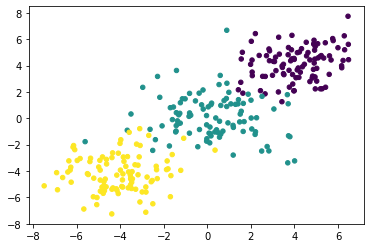

In [4]:
y_cat = to_categorical(y)
plt.scatter(X[:,0], X[:,1], c=y, s=20)
plt.show()

# Armamos modelo

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [6]:
input_features = 2
output_size = y_cat.shape[1]
model = Sequential()
layer_a = Dense(output_size,input_dim=input_features, activation='softmax', name="Capa_Oculta")
model.add(layer_a)
model.summary()
lr = 0.04 

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [7]:
X.shape, y.shape

((300, 2), (300,))

In [8]:
batch_size = 20
epochs = 10
model.fit(X, 
          y_cat, 
          # batch_size = batch_size,
          epochs=epochs, 
          verbose=1
         )

Epoch 1/10
10/10 [==============================] - 0s 0s/step - loss: 2.8819 - accuracy: 0.2467
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.7904 - accuracy: 0.6167
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5817 - accuracy: 0.7200
Epoch 4/10
10/10 [==============================] - 0s 801us/step - loss: 0.4681 - accuracy: 0.7633
Epoch 5/10
10/10 [==============================] - 0s 701us/step - loss: 0.3448 - accuracy: 0.8533
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2593 - accuracy: 0.9333
Epoch 7/10
10/10 [==============================] - 0s 701us/step - loss: 0.2315 - accuracy: 0.9500
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.9533
Epoch 9/10
10/10 [==============================] - 0s 801us/step - loss: 0.1992 - accuracy: 0.9500
Epoch 10/10
10/10 [==============================] - 0s 901us/step - loss: 0.1885 - accuracy: 0.9500


10/10 [==============================] - 0s 701us/step - loss: 0.1831 - accuracy: 0.9500


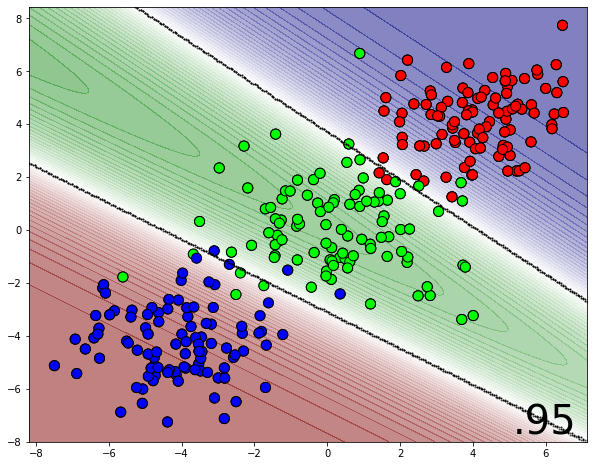

In [9]:
f, (ax1) = plt.subplots(1, 1, figsize=(10,8))
score = model.evaluate(X, y_cat)
plot_MC_boundaries_keras(X, y_cat, score[1], model.predict, ax=ax1, mesh_res = 300)
plt.show()

# Calculos manuales de h, p y loss

## Que parámetros aprendió el modelo?

In [10]:
mw = model.get_weights()
mw

[array([[ 0.95177877,  0.32537913, -0.2542495 ],
        [ 0.7389968 ,  0.04046322, -0.80383945]], dtype=float32),
 array([-1.1415083,  1.469073 , -1.1280857], dtype=float32)]

In [11]:
coefs_, intercept_ = model.get_weights()

In [12]:
coefs_

array([[ 0.95177877,  0.32537913, -0.2542495 ],
       [ 0.7389968 ,  0.04046322, -0.80383945]], dtype=float32)

In [13]:
intercept_

array([-1.1415083,  1.469073 , -1.1280857], dtype=float32)

In [14]:
coefs_ = np.array(coefs_)

In [15]:
intercept_ = np.array(intercept_)

In [46]:
coefs_ = np.array([
[ 1.2032 , 0.34239826, -0.3272417 ],
[ 1.4500312 , 0.54530275, -0.64213556]
])

In [47]:
intercept_ = np.array([-1.7683319, 1.8029612, -1.7188473])

## Probabilidad de observación

In [16]:
observ = np.array([[0, 2]])
print(observ)

[[0 2]]


In [18]:
probs = model.predict(observ)
probs

array([[0.22667477, 0.7628264 , 0.01049886]], dtype=float32)

In [19]:
np.array(probs).sum()

1.0

In [20]:
# Cálculo de h_i
h_s = coefs_.T.dot(observ.reshape(-1,1)) + intercept_.reshape(-1,1)
h_s

array([[ 0.33648527],
       [ 1.54999949],
       [-2.73576462]])

In [21]:
p_ = np.exp(h_s) / np.exp(h_s).sum()
p_

array([[0.22667476],
       [0.76282638],
       [0.01049886]])

## Cálculo de loss

In [21]:
model.evaluate(observ, np.array([[1, 0, 0]]))

1/1 [==============================] - 0s 1ms/step - loss: 1.7517 - accuracy: 0.0000e+00


[1.7517476081848145, 0.0]

In [24]:
- np.log(p_[0])

array([1.75174759])

In [25]:
-np.log(p_[0]), -np.log(p_[1])

(array([1.75174759]), array([0.22456822]))

In [23]:
np.exp(-0.023281602)

0.9769873234479889

In [24]:
-np.log(0.9769873234479889)

0.023281601999999967

# Modelo con pivot (w1 = 0)

In [22]:
#Haciendo w0.1 = w1.1 = w2.1 = 0 => h1 = 0
mwpivot = [mw[0] - np.array([[mw[0][0][0], mw[0][0][0], mw[0][0][0]], [mw[0][1][0], mw[0][1][0], mw[0][1][0]]], dtype = float), mw[1]- np.array([mw[1][0], mw[1][0], mw[1][0]])]
mwpivot

[array([[ 0.        , -0.62639964, -1.20602828],
        [ 0.        , -0.69853359, -1.54283625]]),
 array([0.        , 2.6105814 , 0.01342261], dtype=float32)]

In [23]:
layer_a.set_weights(mwpivot)

In [24]:
model.get_weights()

[array([[ 0.        , -0.62639964, -1.2060282 ],
        [ 0.        , -0.6985336 , -1.5428362 ]], dtype=float32),
 array([0.        , 2.6105814 , 0.01342261], dtype=float32)]

In [27]:
#Observar que las probabilidades son iguales
probs = model.predict(observ)
probs

array([[0.22667477, 0.7628264 , 0.01049886]], dtype=float32)

In [31]:
coefs_, intercept_ = model.get_weights()

In [34]:
#NOTAR QUE EL CALCULO DE H DIFIERE!
h_s = coefs_.T.dot(observ.reshape(-1,1)) + intercept_.reshape(-1,1)
h_s

array([[ 0.        ],
       [ 1.21351421],
       [-3.07224977]])

In [33]:
#Notar que las probabilidades son iguales
p_ = np.exp(h_s) / np.exp(h_s).sum()
p_

array([[0.22667477],
       [0.76282638],
       [0.01049886]])

10/10 [==============================] - 0s 601us/step - loss: 0.1831 - accuracy: 0.9500


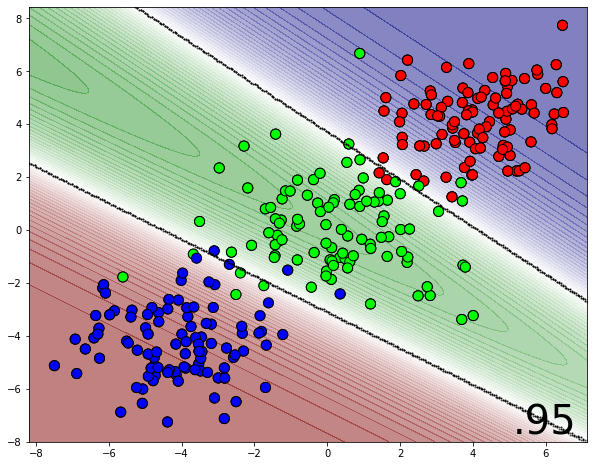

In [29]:
f, (ax1) = plt.subplots(1, 1, figsize=(10,8))
score = model.evaluate(X, y_cat)
plot_MC_boundaries_keras(X, y_cat, score[1], model.predict, ax=ax1, mesh_res = 300)
plt.show()

In [ ]:
# Dado que se puede considerar que P(Y=1/X) es una variable dependiente de P(Y=i/X) con i != 0, 
#para el caso de categorical cross entropy y softmax en realidad se estiman D.(C-1)+(C-1) parametros ya que w1 = 0
#lo mismo que para la regresion logistica binaria